<a href="https://www.kaggle.com/code/jackelinegregorio/delivery-center-food-goods-br-eda-rl-isolation?scriptVersionId=199686042" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Importando as bibliotecas

In [1]:
!pip install chardet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 3.6 MB/s eta 0:00:00


### 1. Leitura das bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import chardet
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/brazilian-delivery-center/drivers.csv
/kaggle/input/brazilian-delivery-center/channels.csv
/kaggle/input/brazilian-delivery-center/deliveries.csv
/kaggle/input/brazilian-delivery-center/hubs.csv
/kaggle/input/brazilian-delivery-center/orders.csv
/kaggle/input/brazilian-delivery-center/stores.csv
/kaggle/input/brazilian-delivery-center/payments.csv


### 2. Leitura da base de dados 

In [3]:
channels = pd.read_csv("../input/brazilian-delivery-center/channels.csv")
deliveries = pd.read_csv("../input/brazilian-delivery-center/deliveries.csv")
drivers = pd.read_csv("../input/brazilian-delivery-center/drivers.csv")
orders = pd.read_csv("../input/brazilian-delivery-center/orders.csv")
payments = pd.read_csv("../input/brazilian-delivery-center/payments.csv")

with open('/kaggle/input/brazilian-delivery-center/hubs.csv', 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']
hubs = pd.read_csv('/kaggle/input/brazilian-delivery-center/hubs.csv', encoding=encoding)
with open('/kaggle/input/brazilian-delivery-center/stores.csv', 'rb') as f:
    result = chardet.detect(f.read())
stores = pd.read_csv('/kaggle/input/brazilian-delivery-center/stores.csv', encoding=encoding)

Como mencionado na tela inicial do dataset (https://www.kaggle.com/datasets/nosbielcs/brazilian-delivery-center/data), temos cerca de seis datasets, onde cada um tem uma informação útil, a seguir:

1. channels: Este dataset possui informações sobre os canais de venda (marketplaces) onde são vendidos os good e food de nossos lojistas.
2. deliveries: Este dataset possui informações sobre as entregas realizadas por nossos entregadores parceiros.
3. drivers: Este dataset possui informações sobre os entregadores parceiros. Eles ficam em nossos hubs e toda vez que um pedido é processado, são eles fazem as entregas na casa dos consumidores.
4. hubs: Este dataset possui informações sobre os hubs do Delivery Center. Entenda que os Hubs são os centros de distribuição dos pedidos e é dali que saem as entregas.
5. orders: Este dataset possui informações sobre as vendas processadas através da plataforma do Delivery Center.
6. payments: Este dataset possui informações sobre os pagamentos realizados ao Delivery Center.
7. stores: Este dataset possui informações sobre os lojistas. Eles utilizam a Plataforma do Delivery Center para vender seus itens (good e/ou food) nos marketplaces.

O que me interessou, a pricipio, foi explorar as informações sobre os pagamentos, no dataset **payments**  e o **hubs**, a fim de explorar a maior metrópole do país, a cidade de São Paulo. Mas isso não quer dizer que não iremos usar os outros datasets, pois o objetivo é fazer um estudo aprofundado com as informações que temos.

A seguir, iremos explorar o dataset *payments*.

In [4]:
payments.head(10)

,payment_id,payment_order_id,payment_amount,payment_fee,payment_method,payment_status
0,4427917,68410055,118.44,0.00,VOUCHER,PAID
1,4427918,68410055,394.81,7.90,ONLINE,PAID
2,4427941,68412721,206.95,5.59,ONLINE,PAID
3,4427948,68413340,58.80,1.59,ONLINE,PAID
4,4427955,68414018,45.80,0.92,ONLINE,PAID
5,4427956,68414309,106.80,2.88,ONLINE,PAID
6,4427961,68414512,57.80,1.56,ONLINE,PAID
7,4427963,68414563,26.90,0.40,ONLINE,PAID
8,4427975,68415103,115.50,3.12,ONLINE,PAID
9,4427976,68415140,199.30,5.38,ONLINE,PAID


### Informação sobre os tipos de cada coluna dos datasets

In [5]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400834 entries, 0 to 400833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   payment_id        400834 non-null  int64  
 1   payment_order_id  400834 non-null  int64  
 2   payment_amount    400834 non-null  float64
 3   payment_fee       400659 non-null  float64
 4   payment_method    400834 non-null  object 
 5   payment_status    400834 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 18.3+ MB


In [6]:
hubs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hub_id         32 non-null     int64  
 1   hub_name       32 non-null     object 
 2   hub_city       32 non-null     object 
 3   hub_state      32 non-null     object 
 4   hub_latitude   32 non-null     float64
 5   hub_longitude  32 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.6+ KB


### 3. Contagem de valores nulos

In [7]:
payments.isnull().sum()

payment_id            0
payment_order_id      0
payment_amount        0
payment_fee         175
payment_method        0
payment_status        0
dtype: int64

In [8]:
hubs.isnull().sum()

hub_id           0
hub_name         0
hub_city         0
hub_state        0
hub_latitude     0
hub_longitude    0
dtype: int64

### 4. Valores duplicados

In [9]:
payments.duplicated().sum()

0

In [10]:
hubs.duplicated().sum()

0

#### Temos os valores de cada pedido, é interessante explorarmos a média dos valores, a mediana e a distribuição desses valores.

In [11]:
payments_amount = payments['payment_amount'].mean()
payments_amount

93.08926119041799

In [12]:
payments_amount = payments['payment_amount'].median()
payments_amount

65.88

In [13]:
payments_amount = payments['payment_amount'].describe()
payments_amount

count    400834.000000
mean         93.089261
std         221.947167
min           0.000000
25%          32.700000
50%          65.880000
75%         121.400000
max      100000.110000
Name: payment_amount, dtype: float64

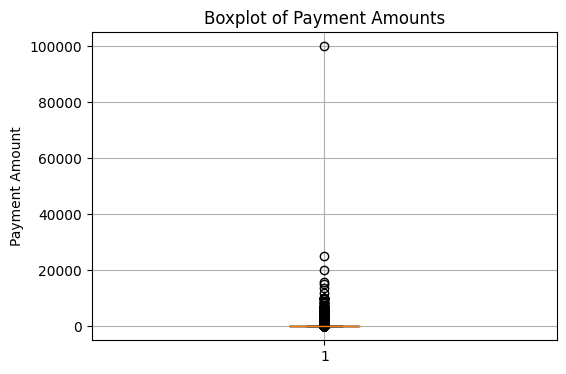

In [14]:
plt.figure(figsize=(6, 4))
plt.boxplot(payments['payment_amount'])
plt.title('Boxplot of Payment Amounts')
plt.ylabel('Payment Amount')
plt.grid(True)
plt.show()

### 5. Tipos de pagamentos no delivery

In [15]:
payment_counts = payments['payment_method'].value_counts().reset_index()
payment_counts.columns = ['payment_method', 'count']

fig = px.bar(payment_counts, x='payment_method', y='count', 
             title=' Payment Method Summary', 
             labels={'payment_method': 'Payment Method', 'count': 'Count'},
             color='payment_method')
fig.show()

In [16]:
payments['payment_method'].value_counts()

payment_method
ONLINE                      312377
VOUCHER                      48570
DEBIT                        12347
MEAL_BENEFIT                  6687
STORE_DIRECT_PAYMENT          6574
CREDIT                        4966
DEBIT_STORE                   1997
VOUCHER_STORE                 1683
PAYMENT_LINK                  1613
CREDIT_STORE                  1266
MONEY                         1190
VOUCHER_DC                     465
INSTALLMENT_CREDIT_STORE       452
VOUCHER_OL                     347
BANK_TRANSFER_DC               300
Name: count, dtype: int64

In [17]:
deliveries.head()

,delivery_id,delivery_order_id,driver_id,delivery_distance_meters,delivery_status
0,2174658,68413340,8378.0,5199.0,DELIVERED
1,2174660,68414309,2473.0,410.0,DELIVERED
2,2174661,68416230,7615.0,3784.0,DELIVERED
3,2174663,68412721,8378.0,5714.0,DELIVERED
4,2174675,68414018,10463.0,3746.0,DELIVERED


In [18]:
deliveries['delivery_status'].nunique()

3

In [19]:
deliveries['delivery_status'].value_counts()

delivery_status
DELIVERED     371367
CANCELLED       7253
DELIVERING       223
Name: count, dtype: int64

In [20]:
status_counts = deliveries['delivery_status'].value_counts().reset_index()
status_counts.columns = ['delivery_status', 'count']
delivery = px.pie(
    status_counts, 
    names='delivery_status', 
    values='count', 
    title='Delivery Status: Distribuição',
    color_discrete_sequence=px.colors.sequential.Viridis
)

# Exibir o gráfico
delivery.show()

### 4. Previsão de Volume de Pagamentos por Hub


In [21]:
hubs_sp = hubs[hubs['hub_state'] == 'SP']
hubs_sp

,hub_id,hub_name,hub_city,hub_state,hub_latitude,hub_longitude
7,17,SMALL SHOPPING,SÃO PAULO,SP,-23.592004,-46.636504
10,21,WOLF SHOPPING,SÃO PAULO,SP,-23.550407,-46.697316
12,25,AVENUE SHOPPING,SÃO PAULO,SP,-23.567703,-46.642043
13,26,SQL SHOPPING,SÃO PAULO,SP,-23.563019,-46.652621
14,27,SAMPA SHOPPING,SÃO PAULO,SP,-23.622995,-46.699204
15,28,RAP SHOPPING,SÃO PAULO,SP,-23.595001,-46.685984
16,29,SUBWAY SHOPPING,SÃO PAULO,SP,-23.561053,-46.558976
17,31,PAGODE SHOPPING,SÃO PAULO,SP,-23.629826,-46.735203
18,33,COFFEE SHOPPING,SÃO PAULO,SP,-23.579067,-46.592820
21,37,RIVER SHOPPING,SÃO PAULO,SP,-23.507105,-46.718197


In [22]:
payments

,payment_id,payment_order_id,payment_amount,payment_fee,payment_method,payment_status
0,4427917,68410055,118.44,0.00,VOUCHER,PAID
1,4427918,68410055,394.81,7.90,ONLINE,PAID
2,4427941,68412721,206.95,5.59,ONLINE,PAID
3,4427948,68413340,58.80,1.59,ONLINE,PAID
4,4427955,68414018,45.80,0.92,ONLINE,PAID
...,...,...,...,...,...,...
400829,5535356,92271189,15.80,0.24,PAYMENT_LINK,PAID
400830,5535359,90051751,93.30,1.87,PAYMENT_LINK,PAID
400831,5536362,92645440,43.20,0.65,STORE_DIRECT_PAYMENT,PAID
400832,5538634,92332079,59.90,0.90,PAYMENT_LINK,PAID


In [23]:
orders.head()

,order_id,store_id,channel_id,payment_order_id,delivery_order_id,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,...,order_moment_delivering,order_moment_delivered,order_moment_finished,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time
0,68405119,3512,5,68405119,68405119,CANCELED,62.7,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68405123,3512,5,68405123,68405123,CANCELED,62.7,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68405206,3512,5,68405206,68405206,CANCELED,115.5,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68405465,3401,5,68405465,68405465,CANCELED,55.9,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,68406064,3401,5,68406064,68406064,CANCELED,37.9,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
payments_encoded = pd.get_dummies(payments, columns=['payment_method', 'payment_status'])
payments_encoded_cleaned = payments_encoded.dropna()

### 6. Modelo usando Regressão Linear

In [25]:
X_clean = payments_encoded_cleaned.drop(columns=['payment_id', 'payment_order_id', 'payment_amount'])
y_clean = payments_encoded_cleaned['payment_amount']

In [26]:
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [27]:
model = LinearRegression()
model.fit(X_train_clean, y_train_clean)

LinearRegression()

In [28]:
y_pred_clean = model.predict(X_test_clean)

In [29]:
r2_cleaned = r2_score(y_test_clean, y_pred_clean)
rmse_cleaned = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))

print(f"R²: {r2_cleaned}")
print(f"RMSE: {rmse_cleaned}")

R²: 0.9295036365716884
RMSE: 37.54218294132573


### 7. Detecção de Anomalias com Isolation Forest

In [30]:
from sklearn.ensemble import IsolationForest

In [31]:
anomaly_detection = payments[['payment_amount', 'payment_fee']]
anomaly_detection = anomaly_detection.dropna()

iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(anomaly_detection)

# Prever anomalias (-1 é uma anomalia, 1 é normal)
anomalies = iso_forest.predict(anomaly_detection[['payment_amount', 'payment_fee']])
anomaly_detection['is_anomaly'] = anomalies

num_anomalies = (anomaly_detection['is_anomaly'] == -1).sum()
print(f"Número de anomalias detectadas: {num_anomalies}")

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



Número de anomalias detectadas: 3984


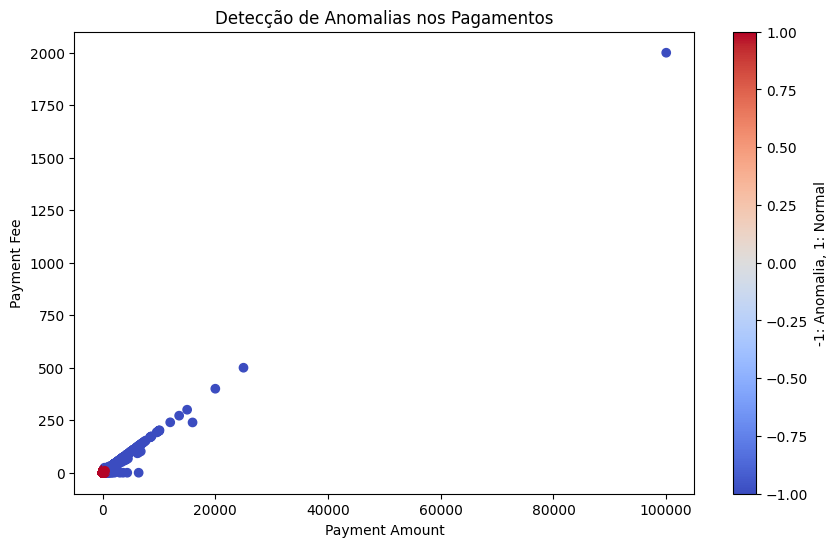

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(anomaly_detection['payment_amount'], anomaly_detection['payment_fee'], 
            c=anomaly_detection['is_anomaly'], cmap='coolwarm')
plt.xlabel('Payment Amount')
plt.ylabel('Payment Fee')
plt.title('Detecção de Anomalias nos Pagamentos')
plt.colorbar(label='-1: Anomalia, 1: Normal')
plt.show()

Os pontos que são marcados como -1 podem representar transações com valores de pagamento ou taxas incomuns em comparação com o restante dos dados.

O modelo identificou 3.984 anomalias nos pagamentos, e o gráfico visualiza essas anomalias como pontos destacados de cor diferente.

Esses pontos representam transações com valores de **payment_amount** e **payment_fee** que se desviam significativamente do padrão que temos no dataset.

In [33]:
anomalous_transactions = anomaly_detection[anomaly_detection['is_anomaly'] == -1]
print(anomalous_transactions.describe())


       payment_amount  payment_fee  is_anomaly
count     3984.000000  3984.000000      3984.0
mean       923.930733    18.467593        -1.0
std       1934.716159    38.353343         0.0
min        210.700000     0.000000        -1.0
25%        500.000000    10.570000        -1.0
50%        599.990000    12.225000        -1.0
75%        867.847500    17.125000        -1.0
max     100000.110000  2000.000000        -1.0


Valores de Pagamento Altos e Dispersos:

* O valor médio de payment_amount para as anomalias é 923.93, mas o desvio padrão é muito alto (1934.72), o que indica uma grande variação;
* O valor máximo chega a 100.000,11, o que é significativamente mais alto do que a maioria das transações. Isso pode indicar transações potencialmente fraudulentas ou excepcionais.

Taxas de Pagamento (payment_fee) Variadas:

* A média das taxas é de 18.47, mas o desvio padrão também é grande (38.35);
* O valor máximo de 2000.00 pode ser anômalo, dependendo das regras de negócio.

Distribuição dos Valores:
* A mediana (50%) do payment_amount é de 599.99, o que mostra que metade das transações anômalas está abaixo desse valor. No entanto, o fato de ter algumas transações extremamente altas eleva a média;
* Da mesma forma, o payment_fee tem uma mediana de 12.22, mas há transações com taxas muito altas.

### 8. Usando novos targets e nova amostra

* Como o parâmetro contamination = 0.01, indica que 1% das transações devem ser consideradas anomalias, essa proporção é aplicada à amostra menor, resultando em um número reduzido de anomalias;

In [34]:
payments_df = payments.copy()

anomaly_detection = payments_df[['payment_amount', 'payment_fee', 'payment_method', 'payment_status']]
anomaly_detection = pd.get_dummies(anomaly_detection, columns=['payment_method', 'payment_status'])
anomaly_detection['amount_fee_ratio'] = anomaly_detection['payment_amount'] / (anomaly_detection['payment_fee'] + 1)
anomaly_detection = anomaly_detection.dropna()

# Amostra menor dos dados para melhorar a performance (10%)
anomaly_detection_sample = anomaly_detection.sample(frac=0.1, random_state=42)

# Criar e ajustar o modelo Isolation Forest com a amostra
iso_forest_sample = IsolationForest(contamination=0.01, random_state=42)
iso_forest_sample.fit(anomaly_detection_sample)

anomalies_sample = iso_forest_sample.predict(anomaly_detection_sample)
anomaly_detection_sample['is_anomaly'] = anomalies_sample

num_anomalies_sample = (anomaly_detection_sample['is_anomaly'] == -1).sum()
print(f"Número de anomalias detectadas com variáveis adicionais na amostra: {num_anomalies_sample}")

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



Número de anomalias detectadas com variáveis adicionais na amostra: 401


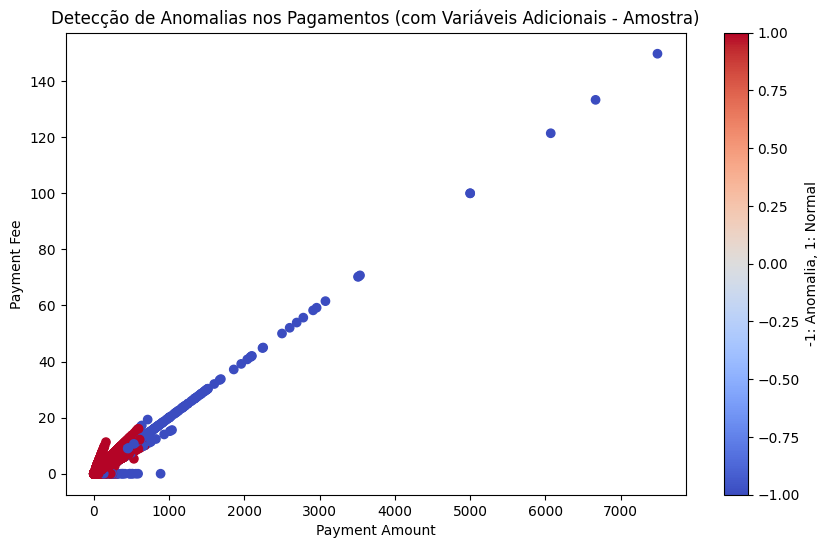

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(anomaly_detection_sample['payment_amount'], anomaly_detection_sample['payment_fee'], 
            c=anomaly_detection_sample['is_anomaly'], cmap='coolwarm')
plt.xlabel('Payment Amount')
plt.ylabel('Payment Fee')
plt.title('Detecção de Anomalias nos Pagamentos (com Variáveis Adicionais - Amostra)')
plt.colorbar(label='-1: Anomalia, 1: Normal')
plt.show()